In [ ]:
# Setup
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['font.size'] = 20
data_dir = './' #os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision as tv
import torchvision.transforms as tvtf
from utils.data import MNISTMDataset
from utils.plot_utils import dataset_first_n

image_size = 28
batch_size = 4
tf_source = tvtf.Compose([ tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.1307,), std=(0.3081,)) ])
tf_target = tvtf.Compose([
    tvtf.Resize(image_size), tvtf.ToTensor(), tvtf.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

ds_source = tv.datasets.MNIST(root=data_dir, train=True, transform=tf_source, download=True)

# Custom PyTorch Dataset class to load MNIST-M
ds_target = MNISTMDataset(os.path.join(data_dir, 'mnist_m', 'mnist_m_train'),
                            os.path.join(data_dir, 'mnist_m', 'mnist_m_train_labels.txt'),
                            transform=tf_target)

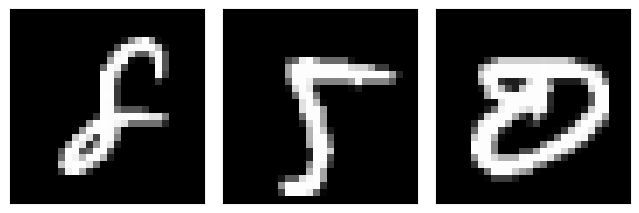

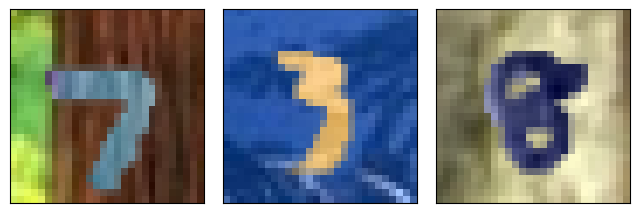

In [15]:
# Show a few random images from each dataset
dataset_first_n(ds_source, 3, cmap='gray', random_start=True);
dataset_first_n(ds_target, 3, random_start=True);

In [16]:
# Dataloaders
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

In [17]:
from torch.autograd import Function

class GradientReversalFn(Function):
    @staticmethod
    def forward(ctx, x, λ):
        # Store context for backprop
        ctx.λ = λ
        
        # Forward pass is a no-op
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # grad_output is dL/dx (since our forward's output was x)
        
        # Backward pass is just to apply -λ to the gradient
        # This will become the new dL/dx in the previous parts of the network
        output =  - ctx.λ * grad_output

        # Must return number of inputs to forward()
        return output, None

In [ ]:
w = torch.tensor([1,2,3,4.], requires_grad=True)
t = 2 * w + 1 # What should the gradient w.r.t. w be?
                # dt/dw = 2
t = GradientReversalFn.apply(t, 0.25)
            # lambda = 0.25
            # t is x in the forward(ctx, x, λ) function 
t


tensor([3., 5., 7., 9.], grad_fn=<GradientReversalFnBackward>)

In [ ]:
loss = torch.sum(t)
loss.backward(retain_graph=True) # don't discard computation graph during backward, for later vizualization
w.grad  # = dt/dw * 0.25 

tensor([-0.5000, -0.5000, -0.5000, -0.5000])

In [24]:
# import torchviz
# torchviz.make_dot(loss, params=dict(w=w))

In [25]:
import torch.nn as nn

class DACNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=1, stride=1),  # (28+2P-F)/S + 1 = 26
            nn.BatchNorm2d(64), nn.MaxPool2d(2), nn.ReLU(True),    # 26 / 2 = 13
            nn.Conv2d(64, 50, kernel_size=5, padding=1, stride=1), # (12+2P-F)/S + 1 = 10
            nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True),    # 10 / 2 = 5
            nn.Dropout2d(),
        )
        self.num_cnn_features = 50 * 5 * 5 # Assuming 28x28 input
        
        self.class_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1),
        )
        
        self.domain_classifier = nn.Sequential(
            nn.Linear(self.num_cnn_features, 100),
            nn.BatchNorm1d(100), nn.ReLU(True),
            nn.Linear(100, 2),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, x, λ=1.0):
        # Handle single-channel input by expanding (repeating) the singleton dimension
        x = x.expand(x.data.shape[0], 3, image_size, image_size)
        
        features = self.feature_extractor(x)
        features = features.view(-1, self.num_cnn_features)
        features_grl = GradientReversalFn.apply(features, λ)
        class_pred = self.class_classifier(features)        # classify on regular features
        domain_pred = self.domain_classifier(features_grl)  # classify on features after GRL
        return class_pred, domain_pred

In [26]:
model = DACNN()

x0_s, y0_s = next(iter(dl_source))
x0_t, y0_t = next(iter(dl_target))

print('source domain input: ', x0_s.shape, y0_s.shape)
print('target domain input: ', x0_t.shape, y0_t.shape)

# Test that forward pass on both domains:
# get class prediction and domain prediction
yhat0_s_c, yhat0_s_d = model(x0_s)
yhat0_t_c, yhat0_t_d = model(x0_t)

print('yhat0_t_c:\n', yhat0_t_c, yhat0_t_c.shape)
print('yhat0_t_d:\n', yhat0_t_d, yhat0_t_d.shape)

source domain input:  torch.Size([4, 1, 28, 28]) torch.Size([4])
target domain input:  torch.Size([4, 3, 28, 28]) torch.Size([4])
yhat0_t_c:
 tensor([[-2.7460, -1.7080, -2.4605, -3.1144, -2.6539, -2.5012, -2.4949, -2.3638,
         -2.2337, -1.6675],
        [-2.3809, -1.9238, -2.0054, -2.3183, -2.5667, -2.5296, -2.8246, -2.1515,
         -2.1122, -2.5857],
        [-2.3538, -1.9615, -2.4013, -2.6721, -2.0136, -1.8868, -2.4160, -2.8384,
         -2.6450, -2.2949],
        [-2.8291, -2.5264, -2.3965, -1.9347, -2.4801, -2.3705, -2.8949, -1.9190,
         -2.4992, -1.8073]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 10])
yhat0_t_d:
 tensor([[-0.3946, -1.1207],
        [-0.6062, -0.7884],
        [-0.8767, -0.5381],
        [-0.7008, -0.6856]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 2])


# Training

In [27]:
import torch.optim as optim

lr = 1e-3
n_epochs = 1

# Setup optimizer as usual
model = DACNN()
optimizer = optim.Adam(model.parameters(), lr)

# Two loss functions this time (can generally be different)
loss_fn_class = torch.nn.NLLLoss()
loss_fn_domain = torch.nn.NLLLoss()

In [28]:
batch_size = 256
dl_source = torch.utils.data.DataLoader(ds_source, batch_size)
dl_target = torch.utils.data.DataLoader(ds_target, batch_size)

# We'll train the same number of batches from both datasets
max_batches = min(len(dl_source), len(dl_target))

In [30]:
for epoch_idx in range(n_epochs):
    print(f'Epoch {epoch_idx+1:04d} / {n_epochs:04d}', end='\n=================\n')
    dl_source_iter = iter(dl_source)
    dl_target_iter = iter(dl_target)

    for batch_idx in range(max_batches):
        # Calculate training progress and GRL λ
        p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
        λ = 2. / (1. + np.exp(-10 * p)) - 1

        # === Train on source domain
        X_s, y_s = next(dl_source_iter)
        y_s_domain = torch.zeros(batch_size, dtype=torch.long) # generate source domain labels: 0

        class_pred, domain_pred = model(X_s, λ)
        loss_s_label = loss_fn_class(class_pred, y_s)           # source classification loss
        loss_s_domain = loss_fn_domain(domain_pred, y_s_domain) # source domain loss (via GRL)

        # === Train on target domain
        X_t, _ = next(dl_target_iter) # Note: ignoring target domain class labels!
        y_t_domain = torch.ones(batch_size, dtype=torch.long) # generate target domain labels: 1

        _, domain_pred = model(X_t, λ)
        loss_t_domain = loss_fn_domain(domain_pred, y_t_domain) # target domain loss (via GRL)
        
        # === Optimize
        loss = loss_t_domain + loss_s_domain + loss_s_label
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        print(f'[{batch_idx+1}/{max_batches}] '
                f'class_loss: {loss_s_label.item():.4f} ' f's_domain_loss: {loss_s_domain.item():.4f} '
                f't_domain_loss: {loss_t_domain.item():.4f} ' f'λ: {λ:.3f} '
            )
        if batch_idx == 10:
            print('This is just a demo, stopping...')
            break

Epoch 0001 / 0001
[1/231] class_loss: 2.3999 s_domain_loss: 0.4737 t_domain_loss: 1.0334 λ: 0.000 
[2/231] class_loss: 2.0178 s_domain_loss: 0.4945 t_domain_loss: 0.9654 λ: 0.022 
[3/231] class_loss: 1.8712 s_domain_loss: 0.5250 t_domain_loss: 0.9058 λ: 0.043 
[4/231] class_loss: 1.7049 s_domain_loss: 0.5619 t_domain_loss: 0.8510 λ: 0.065 
[5/231] class_loss: 1.6233 s_domain_loss: 0.5984 t_domain_loss: 0.8009 λ: 0.086 
[6/231] class_loss: 1.4959 s_domain_loss: 0.6323 t_domain_loss: 0.7630 λ: 0.108 
[7/231] class_loss: 1.3970 s_domain_loss: 0.6713 t_domain_loss: 0.7260 λ: 0.129 
[8/231] class_loss: 1.3417 s_domain_loss: 0.6920 t_domain_loss: 0.6918 λ: 0.150 
[9/231] class_loss: 1.2605 s_domain_loss: 0.7107 t_domain_loss: 0.6734 λ: 0.171 
[10/231] class_loss: 1.1985 s_domain_loss: 0.7347 t_domain_loss: 0.6537 λ: 0.192 
[11/231] class_loss: 1.1287 s_domain_loss: 0.7511 t_domain_loss: 0.6452 λ: 0.213 
This is just a demo, stopping...
